## Algorytm ewolucyjny jako metoda doboru zmiennych do modelu
Jędrzej Adaszyński

Celem analizy jest próba stworzenia od podstaw algorytmu ewolucyjnego, którego celem będzie dobór zmiennych do modelu predykcyjnego. Wybór zmiennych jest kluczowy przy modelach predykcyjnych, a konstrukcja algorytmu ewolucyjnego pozwala samemu stworzyć funckję celu, którą następnie maksymalizuje.

Taka metoda doboru zmiennych może w szczególności przydać się w algorytmach wykorzystywanych w problemach medycznych. Utrzymywanie algorytmów bazujących na wielu zmiennych może być bardzo kosztownych, z racji że w celu pozyskania nowych danych często konieczne są kolejne badania.

Algorytm ewolucyjny jest algorytmem optymalizującym tzn. że przy danych ograniczeniach stara się znaleźć maksywalną lub minimalną wartość zadanej funkcji. W przypadku tej analizy, ograniczeniem będzie liczba zmiennych, a za funkcję celu opowiadać będzie pole pod krzywą ROC, a dalszej części F1-score.

In [ ]:
import numpy as np
import pandas as pd
from random import Random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Pracować będziemy na danych breast_cancer dostępnym w ramach biblioteki Scikit Learn.

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

df = pd.DataFrame(data.data,columns=data.feature_names)
df['target'] = pd.Series(data.target)

y = df.pop('target')
X = df

print(X.shape)

(569, 30)


Dzielimy dane na dwie części - treningowe oraz testowe.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Pierwszym krokiem jest stworzenie funkcji, która pozwoli nam generować początkową populację. Populacja ta będzie losowa. 

Populacja składać się będzie z wektorów, które wykorzystane mogłyby zostać jako potencjalne dobory zmiennych. Przykładowo wektor, który składałby się z wartości 1 na pierwszym miejscu, a na reszcie pozycji zawierał 0, przekładałby się na specyfikację z jedynie pierwszą zmienną jako zmienną objaśniającą.

Funkcja za argumenty brać będzie rozmiar populacji, długość wektora, prawdopodobieństwo z jakim dany element wektora będzie przyjmować wartość 1 oraz ograniczenie na całkowitą sumę elementów.

In [ ]:
def random_population(pop_size, length, p_val, max):
  pop = []
  i = 1
  while i <= pop_size:
    a = np.random.choice([0, 1], size=(length,), p=[1 - p_val, p_val])
    if sum(a) > max or sum(a) == 0:
      i = i -1
    else:
      pop.append(list(a))
    i = i + 1
  return pop

pop = random_population(500, 30, 1/3, 3)

Przykładowy wektor wygląda następująco

In [ ]:
pop[0]

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Stwórzmy teraz funkcję, która przetłumaczy nam ten wektor na numery konkretnych zmiennych.

In [ ]:
def columns_selector(arr):
  i = 0
  result = []
  while i < len(arr):
    if arr[i] == 1:
      result.append(i)
    i = i + 1
  return result

columns_selector(pop[0])

[0, 1, 17]

Konwencja oznaczenia jest spójna z Pythonem tzn. pierwszy element oznaczony jest jako 0, drugi jako 1 itd.

Teraz sprawdźmy jaki wynik osiągnie pierwszy element z wylosowanej populacji.

In [ ]:
auc_roc_scores = []
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train.iloc[:, columns_selector(pop[1])], y_train)
roc_auc_score(y_test, clf.predict_proba(X_test.iloc[:, columns_selector(pop[1])])[:, 1])


0.9136904761904762

Stwórzmy funckcję do wyliczenia wyniku. Funckcja estymować będzie model, a następnie zwracać AUC ROC.

In [ ]:
def calculate_score(columns, trainX, trainy, testX, testy):
  clf = LogisticRegression(random_state=0, max_iter=250).fit(trainX.iloc[:, columns], trainy)
  return roc_auc_score(testy, clf.predict_proba(testX.iloc[:, columns])[:, 1])
  
calculate_score(columns_selector(pop[1]), X_train, y_train, X_test, y_test)

0.9136904761904762

Teraz, w pętli, przeliczać będziemy wynik dla każdej jednostki z populacji. Niektóre z jednostek powtarzają się. W przypadku kiedy wynik dla danej konfiguracji mamy już przeliczony, będzie on kopiwany z tabeli *results* w któej odkładać będziemy wyniki.

In [ ]:
results = pd.DataFrame(columns = ['array', 'columns', 'score'])

for i in pop:
  if str(columns_selector(i)) not in results['columns']:
    results.loc[len(results)] = [str(i) ,columns_selector(i),calculate_score(columns_selector( i ),  X_train, y_train, X_test, y_test)]
  else:
    results.append( results.loc[results['columns'] == str(columns_selector(i)) ] )

results.head()


,array,columns,score
0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 17]",0.911045
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[9, 13, 14]",0.913690
2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 28]",0.921627
3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[2, 9, 18]",0.902116
4,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[2, 10, 12]",0.918651


Teraz musimy wybrać które jednostki będą dalej uwzględniane w procesie doboru. Jest kilka technik takiego doboru. W tym wypadku wykorzytsamy **truncation selection**, czyli wybór jedynie najlepszych przypadków. Taki dobór występuje jedynie w nienaturalnych warunkach, przykładowo w hodowlach, w któych do dalszego rozmnażania wybierane są jedynie najlepsze ze zwierząt pod kątem interesującej nas cechy. Inne przykłady metod selekcji są opisane [w tym artykule](https://en.wikipedia.org/wiki/Selection_(genetic_algorithm)).

In [ ]:
def truncating_selection(population, percent_to_stay, sort_by = 'score'):
  res = population.sort_values(axis = 0, by = sort_by, ascending = False)
  return res[0 : int(len(res) * percent_to_stay / 100)]

results = truncating_selection(results, 50)


Teraz stworzymy mechanizm rozmnażania. Mechanizmem często wykorzystywanym jest tzw. crossover, oparty na mechanizmie występującym podczas wymiany odcinków między chromosami. W tej analizie wykorzystamy dwupunktowy crossover. Mechanizm jest polega na wyznaczeniu dwóch punktów, a następnie wymiany części wektora między tymi punktami. Do wylosowania punktu wykorzystamy rozkład jednostajny, co zagwarantuje nam że każda możliwość wycięcia kawałka jest równie prawdopodbna.

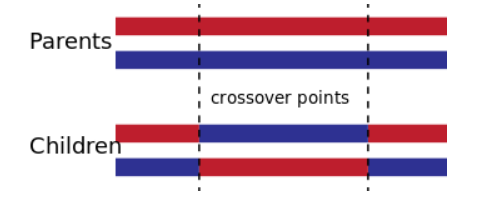

In [ ]:
from random import random
def crossover(x, y):
  if len(x) != len(y):  raise ValueError("Arrays must have the same size")
  cut1 = int(random() * len(x))
  cut2 = int(random() * len(x))

  swap = x[min(cut1, cut2):max(cut1, cut2)]
  x[min(cut1, cut2):max(cut1, cut2)] = y[min(cut1, cut2):max(cut1, cut2)]
  y[min(cut1, cut2):max(cut1, cut2)] = swap

  return x,y

In [ ]:
crossover([1,1,1,1,1,1], [0,0,0,0,0,0])

([0, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0])

Przy takiej metodzie rozmnażania możliwy jest scenariusz, w którym któreś z "dzieci" przekracza ograniczenie. Musimy dodać funkcję, która zapewni nam że nie będzie takiego przypadku. Przy przekroczeniu ograniczenia, poniższa funkcja losowo podmieniać będzie jedynki na zera.

In [ ]:
def check_constraint(array, max_sum):
  from random import choice
  w = list(range(0, len(array)))
  if sum(array) <= max_sum: return array
  else:
    while sum(array) > max_sum:
      array[choice(w) - 1] = 0
  return array
    

Teraz musimy doprecyzować funkcję, która dobierze rodziców do rozmnożenia. Zastosujemy proste podejście tj. każdy z wybranych wcześniej rodziców będzie miał równą szansę zostać wybranym do rozmnożenia.

In [ ]:
from json import loads
def choose_couples(cur_population, p = 'equal'):
  if p == 'equal':
      x = loads(str(cur_population.iloc[int(random() * (len(cur_population) - 1)), 0]))
      y = loads(str(cur_population.iloc[int(random() * (len(cur_population) - 1)), 0]))
      return x,y
  else:
    pass

In [ ]:
results.iloc[int(random() * (len(results) - 1)), 0]
results

,array,columns,score
436,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 3, 23]",0.979167
73,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[12, 21, 23]",0.977183
308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[21, 22, 28]",0.975529
205,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 29]",0.973214
419,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 20, 21]",0.973214
...,...,...,...
122,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[2, 10, 16]",0.910384
252,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[2, 10, 15]",0.910384
28,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 6, 29]",0.910384
443,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[3, 8, 12]",0.910053


In [ ]:
pop = random_population(10, 30, 0.1, 3)
results = pd.DataFrame(columns = ['array', 'columns', 'score'])

for i in pop:
  if str(columns_selector(i)) not in results['columns']:
    results.loc[len(results)] = [str(i) ,columns_selector(i),calculate_score(columns_selector( i ),  X_train, y_train, X_test, y_test)]
  else:
    results.append( results.loc[results['columns'] == str(columns_selector(i)) ] )



In [ ]:
max_scores = []
best_in_generation = []
scores = []


i = 0
while i < 30 :
  results = truncating_selection(results, 50)
  cnt = 0
  while len(results) < 10:
    couple = choose_couples(results)
    a = check_constraint( crossover(couple[0], couple[1])[0], 3 )
    b = check_constraint( crossover(couple[0], couple[1])[1], 3 )
    if sum(a) != 0:
      results.loc[len(results)] = [ str(a) , columns_selector(a), calculate_score(columns_selector( a ),  X_train, y_train, X_test, y_test) ]
    if sum(b) != 0:
      results.loc[len(results)] = [ str(b) , columns_selector(b), calculate_score(columns_selector( b ),  X_train, y_train, X_test, y_test) ]
    cnt = cnt +1
    results = results.reset_index(drop=True)
  best_in_generation.append(results.loc[results['score'].idxmax()][1])
  scores.append( results['score'].mean() )
  max_scores.append( results['score'].max() )

  i = i + 1

results.head()

,array,columns,score
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[9, 13, 22, 26]",0.97123
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[13, 22, 26]",0.97123
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[13, 22, 26]",0.97123
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[13, 22, 26]",0.97123
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[13, 22, 26]",0.97123


Max F1-score: 0.971
for configuration: [9, 13, 22, 26]


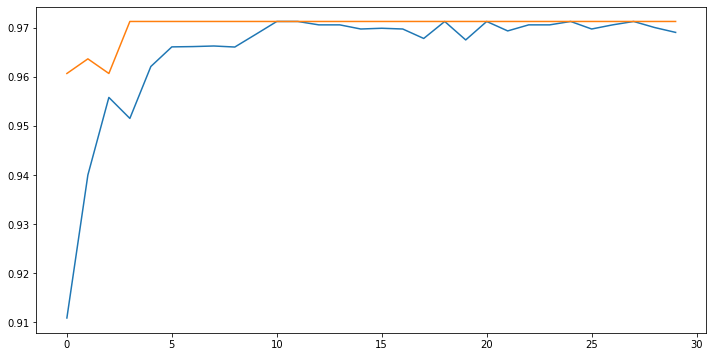

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(scores)
plt.plot(max_scores)
props = dict(boxstyle='round', facecolor='orange', alpha=0.5)
#plt.text(-1,-1, 'Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]),  fontsize=14,
#        verticalalignment='top', bbox=props)
print('Max AUC ROC: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]))

AUC ROC może nie być najlepszą metryką do mierzenia dokładności klasyfikacji w tym przypadku. Przy diagnozowaniu pacjentów interesuje nas, aby z największą pewnością pacjenci byli poprawnie klasyfikowani dla danego cutoffu prawdopodobieństwa, a nie przeciętnie dla całego rozkładu prawdopodobieństwa. Wykorzystamy F1 score, czyli średniej harmonicznej z precyzji i czułości.

In [ ]:
from sklearn.metrics import f1_score

def calculate_score_f1(columns, trainX, trainy, testX, testy):
  clf = LogisticRegression(random_state=0, max_iter=250).fit(trainX.iloc[:, columns], trainy)
  return f1_score(testy, clf.predict(testX.iloc[:, columns]))
  
calculate_score_f1(columns_selector(pop[1]), X_train, y_train, X_test, y_test)

0.9210526315789473

In [ ]:
pop = random_population(10, 30, 0.3,3 )
results = pd.DataFrame(columns = ['array', 'columns', 'score'])

for i in pop:
  if str(columns_selector(i)) not in results['columns']:
    #results[tuple(columns_selector(i))] = calculate_score(columns_selector( i ),  X_train, y_train, X_test, y_test)
    results.loc[len(results)] = [str(i) ,columns_selector(i),calculate_score_f1(columns_selector( i ),  X_train, y_train, X_test, y_test)]
  else:
    results.append( results.loc[results['columns'] == str(columns_selector(i)) ] )

max_scores = []
best_in_generation = []
scores = []

i = 1

while i < 30 :
  results = truncating_selection(results, 50)
  cnt = 0
  while len(results) < 10:
    couple = choose_couples(results)
    children = crossover(couple[0], couple[1])
    a = check_constraint( children[0], 3 )
    b = check_constraint( children[1], 3 )
    if sum(a) != 0:
      results.loc[len(results)] = [ str(a) , columns_selector(a), calculate_score_f1(columns_selector( a ),  X_train, y_train, X_test, y_test) ]
    if sum(b) != 0:
      results.loc[len(results)] = [ str(b) , columns_selector(b), calculate_score_f1(columns_selector( b ),  X_train, y_train, X_test, y_test) ]
    cnt = cnt +1
    results = results.reset_index(drop=True)
  best_in_generation.append(results.loc[results['score'].idxmax()][1])
  scores.append( results['score'].mean() )
  max_scores.append( results['score'].max() )
  i = i + 1

results.head()

,array,columns,score
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20]",0.939597
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20]",0.939597
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20]",0.939597
3,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20]",0.939597
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20]",0.939597


Max F1-score: 0.94
for configuration: [0, 20]


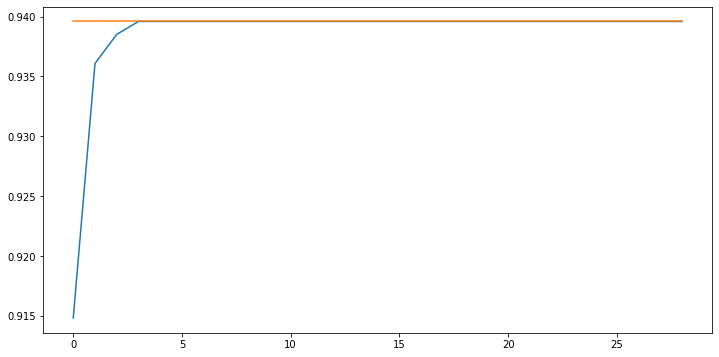

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(scores)
plt.plot(max_scores)
props = dict(boxstyle='round', facecolor='orange', alpha=0.5)
#plt.text(-1,-1, 'Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]),  fontsize=14,
#        verticalalignment='top', bbox=props)
print('Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]))

W wyniku możemy dostrzec, że algorytm szybko wyłapuje dobre rozwiązanie, ale przez niski poziom zmienności, kolejne najlepsze jednostki są identyczne. Do algorytmu dodamy więcej różnorodność poprzez dodanie mechanizmu mutacji.

In [ ]:
def mutate(ar, probability):
  if probability > 1 :  raise ValueError("Maximum value of probability is 1")
  res = ar
  i = 0
  while i < len(res):
    if random() < probability:
      if res[i] ==1: res[i]=0
      else: res[i]=1
    i= i + 1
  return res

Każdy element jest zmieniany z prawdopodobieństwem podanym jako argument funkcji.

In [ ]:
mutate([1,1,1,0,0,1,0], 0.2)

[1, 0, 1, 1, 0, 0, 0]

Sprawdźmy jak algorytm zadziała z mechanizmem mutacji.

In [ ]:
pop = random_population(10, 30, 0.1, 3)
results = pd.DataFrame(columns = ['array', 'columns', 'score'])

for i in pop:
  if str(columns_selector(i)) not in results['columns']:
    #results[tuple(columns_selector(i))] = calculate_score(columns_selector( i ),  X_train, y_train, X_test, y_test)
    results.loc[len(results)] = [str(i) ,columns_selector(i),calculate_score_f1(columns_selector( i ),  X_train, y_train, X_test, y_test)]
  else:
    results.append( results.loc[results['columns'] == str(columns_selector(i)) ] )

max_scores = []
best_in_generation = []
scores = []
scores.append( results['score'].mean() )

i = 1
#conver = 0

while i < 50:
  results = truncating_selection(results, 50)
  cnt = 0
  while len(results) < 10:
    couple = choose_couples(results)
    children = crossover(couple[0], couple[1])
    a = check_constraint( mutate(children[0], 0.1 ), 3)
    b = check_constraint( mutate(children[1], 0.1 ), 3)
    if sum(a) != 0 :#and sum(a) <= 3:
      results.loc[len(results)] = [ str(a) , columns_selector(a), calculate_score_f1(columns_selector( a ),  X_train, y_train, X_test, y_test) ]
    if sum(b) != 0 :#and sum(b) <= 3:
      results.loc[len(results)] = [ str(b) , columns_selector(b), calculate_score_f1(columns_selector( b ),  X_train, y_train, X_test, y_test) ]
    cnt = cnt +1
    results = results.reset_index(drop=True)
  best_in_generation.append(results.loc[results['score'].idxmax()][1])
  scores.append( results['score'].mean() )
  max_scores.append( results['score'].max() )
  conver = ( scores[-1] - sum(scores[-min(3, len(scores)):]) / len(scores[-min(3, len(scores)):]) ) / scores[-1]
  i = i + 1

results.head()

,array,columns,score
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 11, 23]",0.95302
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 11, 23]",0.95302
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 11, 23]",0.95302
3,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 11, 23]",0.95302
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 11, 23]",0.95302


Max F1-score: 0.953
for configuration: [0, 11, 23]


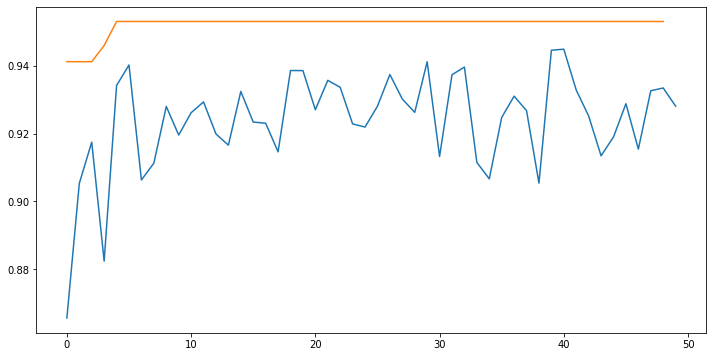

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(scores)
plt.plot(max_scores)
props = dict(boxstyle='round', facecolor='orange', alpha=0.5)
#plt.text(-1,-1, 'Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]),  fontsize=14,
#        verticalalignment='top', bbox=props)
print('Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]))

Spróbujmy zwiekszyć współczynnik odpowiedzialny za prawdopodobieństwo mutacji.

In [ ]:
pop = random_population(10, 30, 0.1, 3)
results = pd.DataFrame(columns = ['array', 'columns', 'score'])

for i in pop:
  if str(columns_selector(i)) not in results['columns']:
    #results[tuple(columns_selector(i))] = calculate_score(columns_selector( i ),  X_train, y_train, X_test, y_test)
    results.loc[len(results)] = [str(i) ,columns_selector(i),calculate_score_f1(columns_selector( i ),  X_train, y_train, X_test, y_test)]
  else:
    results.append( results.loc[results['columns'] == str(columns_selector(i)) ] )

max_scores = []
best_in_generation = []
scores = []
scores.append( results['score'].mean() )

i = 1


while i < 50:
  results = truncating_selection(results, 50)
  cnt = 0
  while len(results) < 10:
    couple = choose_couples(results)
    children = crossover(couple[0], couple[1])
    a = check_constraint( mutate(children[0], 0.7 ), 3)
    b = check_constraint( mutate(children[1], 0.7 ), 3)
    if sum(a) != 0 and sum(a) <= 3:
      results.loc[len(results)] = [ str(a) , columns_selector(a), calculate_score_f1(columns_selector( a ),  X_train, y_train, X_test, y_test) ]
    if sum(b) != 0 and sum(b) <= 3:
      results.loc[len(results)] = [ str(b) , columns_selector(b), calculate_score_f1(columns_selector( b ),  X_train, y_train, X_test, y_test) ]
    cnt = cnt +1
    results = results.reset_index(drop=True)
  best_in_generation.append(results.loc[results['score'].idxmax()][1])
  scores.append( results['score'].mean() )
  max_scores.append( results['score'].max() )

  i = i + 1

results.head()

,array,columns,score
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[10, 20, 21]",0.946667
1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 21, 22]",0.946667
2,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 23]",0.946667
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 28]",0.946667
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[11, 20, 21]",0.945946


Max F1-score: 0.947
for configuration: [10, 20, 21]


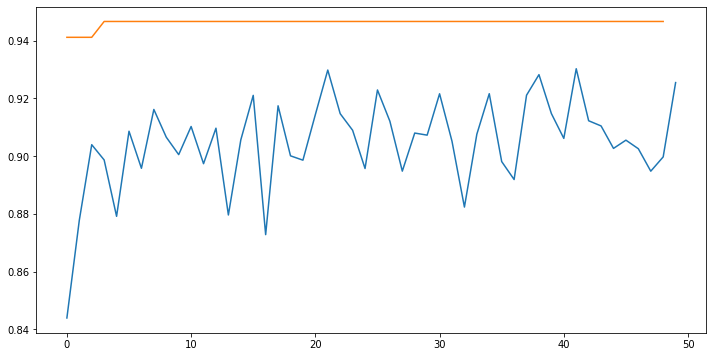

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(scores)
plt.plot(max_scores)
print('Max F1-score: ' + str(round(max(max_scores), 3)) + "\nfor configuration: " + str(results.loc[results['score'].idxmax()][1]))

Wyższy współczynnik mutacji opóźnił znaleznienie najlepszego rozwiązania. Generalnie, poprzez zwiększenie zmienności, opóźniamy znalezienie optimum, ale jednocześnie zapewniamy sobie, że proces będzie bardziej "chętny" do testowania nowych rozwiązań, więc jest większa szansa że znajdzie najlepsze rozwiązanie.

Inny parametr, który możemy dostosowywać to część z danej generacji, którą poddajemy dalszej reprodukcji. Można także dostosowywać mechanizmu samego rozmnażania czy doboru, a także, jak widać po przykłdzie powyżej, dostosować funckję celu, jeśli zajdzie taka potrzeba.